In [2]:
%load_ext autoreload
%autoreload 2

In [41]:
from new_env import CityEnv
import numpy as np
from poly_matrix import polynomial, create_poly_matrix
from stable_baselines3 import PPO
import gymnasium as gym
N = 10
T = 24
poly_matrix = create_poly_matrix(N, T)

class CustomResetWrapper(gym.Wrapper):
    def __init__(self, env, destinations, start_time, start_vertex):
        super().__init__(env)
        self.destinations = destinations
        self.start_time = start_time
        self.start_vertex = start_vertex

    def reset(self, **kwargs):
        # Pass the custom arguments to the environment's reset method
        return self.env.reset(
            destinations=self.destinations,
            start_time=self.start_time,
            start_vertex=self.start_vertex,
            **kwargs
        )
    
# Create the environment
env = CityEnv(poly_matrix=poly_matrix, N = N, time_horizon = T)
destinations = np.array([0, 1, 1, 0, 1, 0, 1, 0, 1, 0])
start_time = 0
start_vertex = 4
env = CustomResetWrapper(env, destinations=destinations, start_time=start_time, start_vertex=start_vertex)

# Initialize the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=10000, progress_bar=True)

# Save the model
model.save("ppo_city_env")

# Load the model (optional)
model = PPO.load("ppo_city_env")

# Evaluate the model
obs = env.reset()
for _ in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    if done:
        obs = env.reset()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


NotImplementedError: Tuple(Box(0.0, inf, (1,), float32), MultiBinary(10), Discrete(10)) observation space is not supported

0.6962022034567503


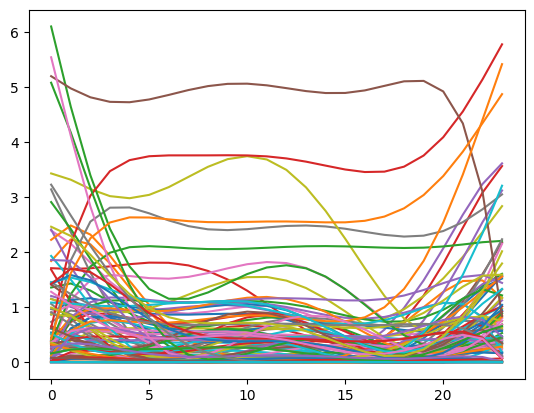

In [35]:

import matplotlib.pyplot as plt
from poly_matrix import polynomial, create_poly_matrix
N = 10
T = 24
count = 0
poly_matrix = create_poly_matrix(N, T)
for i in range(N):
  for j in range(N):
    vals = [poly_matrix[i][j].eval(t) for t in range(T)]
    count += sum(vals)
    plt.plot(vals, label=f"poly_matrix[{i}][{j}]")
print(count / ((N**2 - N) * 24))